<a href="https://colab.research.google.com/github/always-newbie161/probml-notebooks/blob/issue250/notebooks/vdvae_ffhq256_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook loads checkpoints from the **Very deep VAEs** from openai for the **ffhq-256** dataset and visualizes samples.

## Setup

Cloning the vdvae repo.

In [ ]:
!git clone https://github.com/openai/vdvae.git

Cloning into 'vdvae'...
remote: Enumerating objects: 20, done.
remote: Total 20 (delta 0), reused 0 (delta 0), pack-reused 20
Unpacking objects: 100% (20/20), done.


In [ ]:
%cd vdvae

/content/vdvae


Cloning the apex from NVIDIA.

In [ ]:
!pip --quiet install mpi4py
!git clone https://github.com/NVIDIA/apex

     |████████████████████████████████| 1.4MB 5.1MB/s 
Cloning into 'apex'...
remote: Enumerating objects: 8102, done.
remote: Counting objects: 100% (189/189), done.
remote: Compressing objects: 100% (120/120), done.
remote: Total 8102 (delta 92), reused 123 (delta 63), pack-reused 7913
Receiving objects: 100% (8102/8102), 14.15 MiB | 25.33 MiB/s, done.
Resolving deltas: 100% (5493/5493), done.


Installing dependencies for apex.

In [ ]:
%cd apex
!pip --quiet install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./
%cd ..

/content/vdvae/apex
/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/install.py:283: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)
Processing /content/vdvae/apex
Skipping wheel build for apex, due to binaries being disabled for it.
    Running setup.py install for apex ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-req-build-vm1jye1a/setup.py'"'"'; __file__='"'"'/tmp/pip-req-build-vm1jye1a/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' --cpp_ext --cuda_ext install --record /tmp/pip-record-eb9d79d2/install-record.txt --single-version-externally-managed --compile Check the logs for full command output.
/content/vdvae


Loading checkpoints for the model trained on ffhq-256 for 1.7M iterations  (or about 2.5 weeks) on 32 V100.

In [ ]:
# 115M parameters, trained for 1.7M iterations (or about 2.5 weeks) on 32 V100
!wget -q https://openaipublic.blob.core.windows.net/very-deep-vaes-assets/vdvae-assets/ffhq256-iter-1700000-log.jsonl
!wget -q https://openaipublic.blob.core.windows.net/very-deep-vaes-assets/vdvae-assets/ffhq256-iter-1700000-model.th
!wget -q https://openaipublic.blob.core.windows.net/very-deep-vaes-assets/vdvae-assets/ffhq256-iter-1700000-model-ema.th
!wget -q https://openaipublic.blob.core.windows.net/very-deep-vaes-assets/vdvae-assets/ffhq256-iter-1700000-opt.th

## Loading the Model

Note: All the code written in this notebook is referenced from the vdvae repo to make it work on colab.

In [ ]:
%cd /content/vdvae

/content/vdvae


Adding the apex dir to the sys path so that it enables to import modules from apex.

In [ ]:
import sys
sys.path.append('/content/vdvae/apex')

### Setting up the hyperparams

In [ ]:
from hps import HPARAMS_REGISTRY, Hyperparams, add_vae_arguments
from train_helpers import setup_mpi, setup_save_dirs
import argparse

s = None
H = Hyperparams()
parser = argparse.ArgumentParser()
parser = add_vae_arguments(parser)
parser.set_defaults(hparam_sets= 'ffhq256', restore_path='ffhq256-iter-1700000-model.th', 
                    restore_ema_path= 'ffhq256-iter-1700000-model-ema.th', 
                    restore_log_path= 'ffhq256-iter-1700000-log.jsonl',
                    restore_optimizer_path= 'ffhq256-iter-1700000-opt.th')


#parse_args_and_update_hparams(H, parser, s=s)
args = parser.parse_args([])
valid_args = set(args.__dict__.keys())
hparam_sets = [x for x in args.hparam_sets.split(',') if x]
for hp_set in hparam_sets:
    hps = HPARAMS_REGISTRY[hp_set]
    for k in hps:
        if k not in valid_args:
            raise ValueError(f"{k} not in default args")
        parser.set_defaults(**hps)
print(parser.parse_args([]).__dict__)
H.update(parser.parse_args([]).__dict__)

setup_mpi(H)
setup_save_dirs(H)

{'seed': 0, 'port': 29500, 'save_dir': './saved_models', 'data_root': './', 'desc': 'test', 'hparam_sets': 'ffhq256', 'restore_path': 'ffhq256-iter-1700000-model.th', 'restore_ema_path': 'ffhq256-iter-1700000-model-ema.th', 'restore_log_path': 'ffhq256-iter-1700000-log.jsonl', 'restore_optimizer_path': 'ffhq256-iter-1700000-opt.th', 'dataset': 'ffhq_256', 'ema_rate': 0.999, 'enc_blocks': '256x3,256d2,128x8,128d2,64x12,64d2,32x17,32d2,16x7,16d2,8x5,8d2,4x5,4d4,1x4', 'dec_blocks': '1x2,4m1,4x3,8m4,8x4,16m8,16x9,32m16,32x21,64m32,64x13,128m64,128x7,256m128', 'zdim': 16, 'width': 512, 'custom_width_str': '', 'bottleneck_multiple': 0.25, 'no_bias_above': 64, 'scale_encblock': False, 'test_eval': False, 'warmup_iters': 100, 'num_mixtures': 10, 'grad_clip': 130.0, 'skip_threshold': 180.0, 'lr': 0.00015, 'lr_prior': 0.00015, 'wd': 0.01, 'wd_prior': 0.0, 'num_epochs': 10000, 'n_batch': 1, 'adam_beta1': 0.9, 'adam_beta2': 0.9, 'temperature': 1.0, 'iters_per_ckpt': 25000, 'iters_per_print': 1000,

In [ ]:
for k in sorted(H):
    print(f'type=hparam, key={k}, value={H[k]}')

type=hparam, key=adam_beta1, value=0.9
type=hparam, key=adam_beta2, value=0.9
type=hparam, key=bottleneck_multiple, value=0.25
type=hparam, key=custom_width_str, value=
type=hparam, key=data_root, value=./
type=hparam, key=dataset, value=ffhq_256
type=hparam, key=dec_blocks, value=1x2,4m1,4x3,8m4,8x4,16m8,16x9,32m16,32x21,64m32,64x13,128m64,128x7,256m128
type=hparam, key=desc, value=test
type=hparam, key=ema_rate, value=0.999
type=hparam, key=enc_blocks, value=256x3,256d2,128x8,128d2,64x12,64d2,32x17,32d2,16x7,16d2,8x5,8d2,4x5,4d4,1x4
type=hparam, key=epochs_per_eval, value=1
type=hparam, key=epochs_per_eval_save, value=1
type=hparam, key=epochs_per_probe, value=None
type=hparam, key=grad_clip, value=130.0
type=hparam, key=hparam_sets, value=ffhq256
type=hparam, key=iters_per_ckpt, value=25000
type=hparam, key=iters_per_images, value=10000
type=hparam, key=iters_per_print, value=1000
type=hparam, key=iters_per_save, value=10000
type=hparam, key=local_rank, value=0
type=hparam, key=logd

In [ ]:
import numpy as np
import torch
import imageio
from PIL import Image
import glob
from torch.utils.data import DataLoader
from torchvision import transforms


np.random.seed(H.seed)
torch.manual_seed(H.seed)
torch.cuda.manual_seed(H.seed)
print('trained on model', H.dataset)

trained on model ffhq_256


### Preprocess func for the VAE.

In [ ]:
H.image_size = 256
H.image_channels = 3
shift_loss = -127.5
scale_loss = 1. / 127.5
shift = -112.8666757481
scale = 1. / 69.84780273
shift = torch.tensor([shift]).cuda().view(1, 1, 1, 1)
scale = torch.tensor([scale]).cuda().view(1, 1, 1, 1)
shift_loss = torch.tensor([shift_loss]).cuda().view(1, 1, 1, 1)
scale_loss = torch.tensor([scale_loss]).cuda().view(1, 1, 1, 1)
do_low_bit = H.dataset in ['ffhq_256']
untranspose = False

def preprocess_func(x):
    'takes in a data example and returns the preprocessed input'
    'as well as the input processed for the loss'
    if untranspose:
        x[0] = x[0].permute(0, 2, 3, 1)
    inp = x[0].cuda(non_blocking=True).float()
    out = inp.clone()
    inp.add_(shift).mul_(scale)
    if do_low_bit:
      # 5 bits of precision
      out.mul_(1. / 8.).floor_().mul_(8.)
    out.add_(shift_loss).mul_(scale_loss)
    return inp, out

### Loading the checkpointed models.

In [ ]:
from train_helpers import load_vaes
from utils import logger
logprint = logger(H.logdir)
vae, ema_vae = load_vaes(H, logprint)

time: Mon Jul 19 11:02:27 2021, message: Restoring vae from ffhq256-iter-1700000-model.th
time: Mon Jul 19 11:02:29 2021, message: Restoring ema vae from ffhq256-iter-1700000-model-ema.th
time: Mon Jul 19 11:02:30 2021, total_params: 114874852, readable: 114,874,852


### Function to save and show of batch of images given as a numpy array.



In [ ]:
def save_n_show(images, order, image_shape, fname, show=False):
  n_rows, n_images = order
  im = images.reshape((n_rows, n_images, *image_shape))\
          .transpose([0, 2, 1, 3, 4])\
          .reshape([n_rows * image_shape[0], 
                    n_images * image_shape[1], 3])
  print(f'printing samples to {fname}')
  imageio.imwrite(fname, im)
  if show:
    display(Image.open(fname))
  

## Make generations

In [ ]:
n_images = 10
num_temperatures = 3
image_shape = [H.image_size,H.image_size,H.image_channels]
H.update({'num_images_visualize':n_images, 'num_temperatures_visualize':num_temperatures})

Images will be saved in the following dir

In [ ]:
H.save_dir

'./saved_models/test'

In [ ]:
temperatures = [1.0, 0.9, 0.8, 0.7]

for t in temperatures[:H.num_temperatures_visualize]:
    im = ema_vae.forward_uncond_samples(n_images, t=t)
    save_n_show(im, [1,n_images], image_shape, f'{H.save_dir}/generations-tem-{t}.png')

printing samples to ./saved_models/test/generations-tem-1.0.png
printing samples to ./saved_models/test/generations-tem-0.9.png
printing samples to ./saved_models/test/generations-tem-0.8.png


Generation of 10 new images for t=1.0


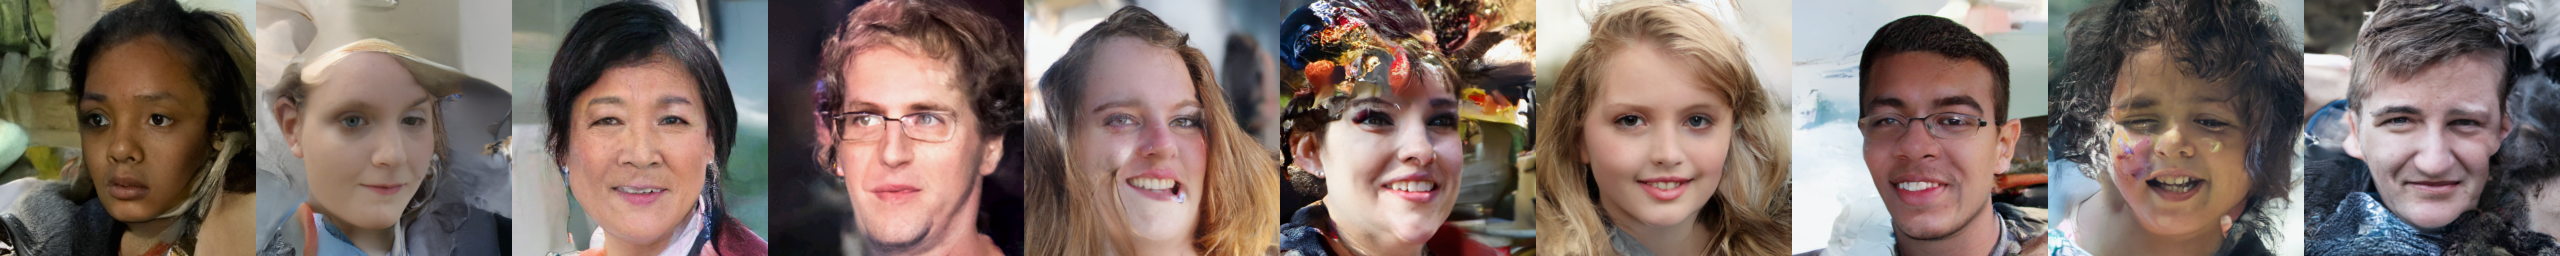

Generation of 10 new images for t=0.9


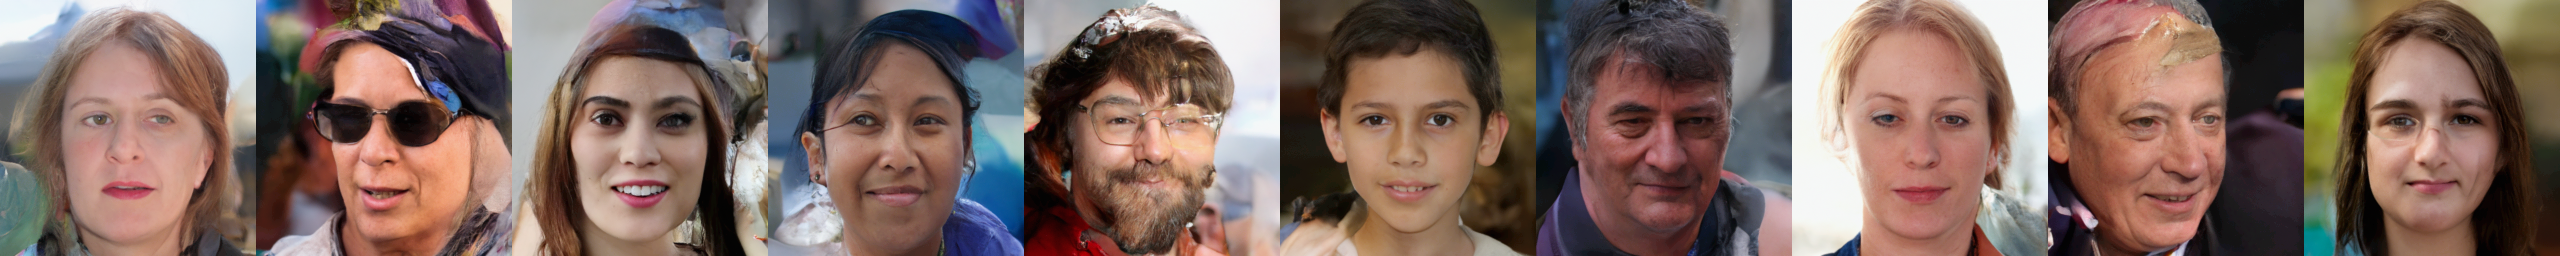

Generation of 10 new images for t=0.8


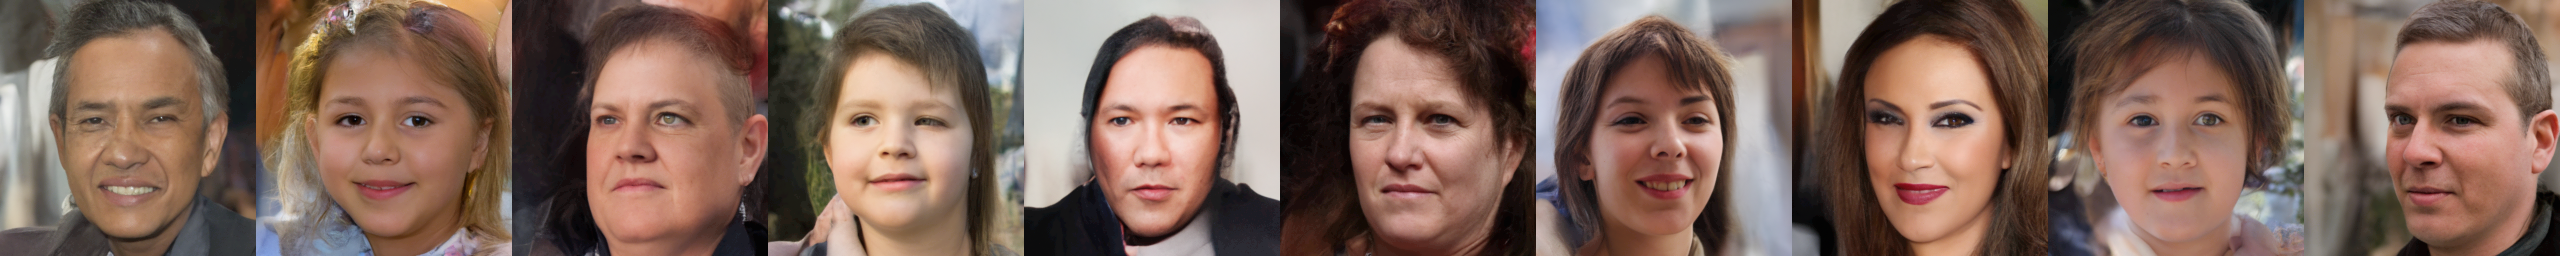

In [ ]:
for t in temperatures[:H.num_temperatures_visualize]:
  print("="*25)
  print(f"Generation of {n_images} new images for t={t}")
  print("="*25)
  fname = f'{H.save_dir}/generations-tem-{t}.png'
  display(Image.open(fname))

## Reconstructions

In [ ]:
n_images = 10
image_shape = [H.image_size,H.image_size,H.image_channels]

### Get API key from Kaggle

Follow [these instructions](https://github.com/Kaggle/kaggle-api#api-credentials) to get a kaggle.json key file. Then upload it to colab.


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!mkdir /root/.kaggle

In [ ]:
!cp kaggle.json /root/.kaggle/kaggle.json

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!rm kaggle.json

### Using CelebA HQ dataset(resized 256x256) test images to make reconstructions.

Dataset is from Kaggle

In [ ]:
!kaggle datasets download -d badasstechie/celebahq-resized-256x256

 99% 281M/283M [00:02<00:00, 144MB/s]
100% 283M/283M [00:02<00:00, 143MB/s]


In [ ]:
!unzip -q /content/vdvae/celebahq-resized-256x256.zip -d /content/

In [ ]:
fnames = glob.glob('/content/celeba_hq_256/*.jpg')
test_images = []
for f in fnames[:n_images]:
  im = np.asarray(Image.open(f))
  test_images.append(torch.Tensor(im).reshape(1,*im.shape))

test_images = torch.cat(test_images)
test_images.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  """


torch.Size([10, 256, 256, 3])

### Getting latents and recons

Preprocessing images before getting the latents

In [ ]:
preprocessed_images = preprocess_func([test_images,_])[0]
preprocessed_images.shape

torch.Size([10, 256, 256, 3])

Getting latents of different levels.

In [ ]:
zs = [s['z'].cuda() for s in ema_vae.forward_get_latents(preprocessed_images)]

No of latent observations used depends on `H.num_variables_visualize `, altering it gives different resolutions of the reconstructions.

In [ ]:
recons = []
lv_points = np.floor(np.linspace(0, 1, H.num_variables_visualize + 2) * len(zs)).astype(int)[1:-1]
for i in lv_points:
  recons.append(ema_vae.forward_samples_set_latents(n_images, zs[:i], t=0.1))


Original Images

Original test images
printing samples to ./saved_models/test/orig_test.png


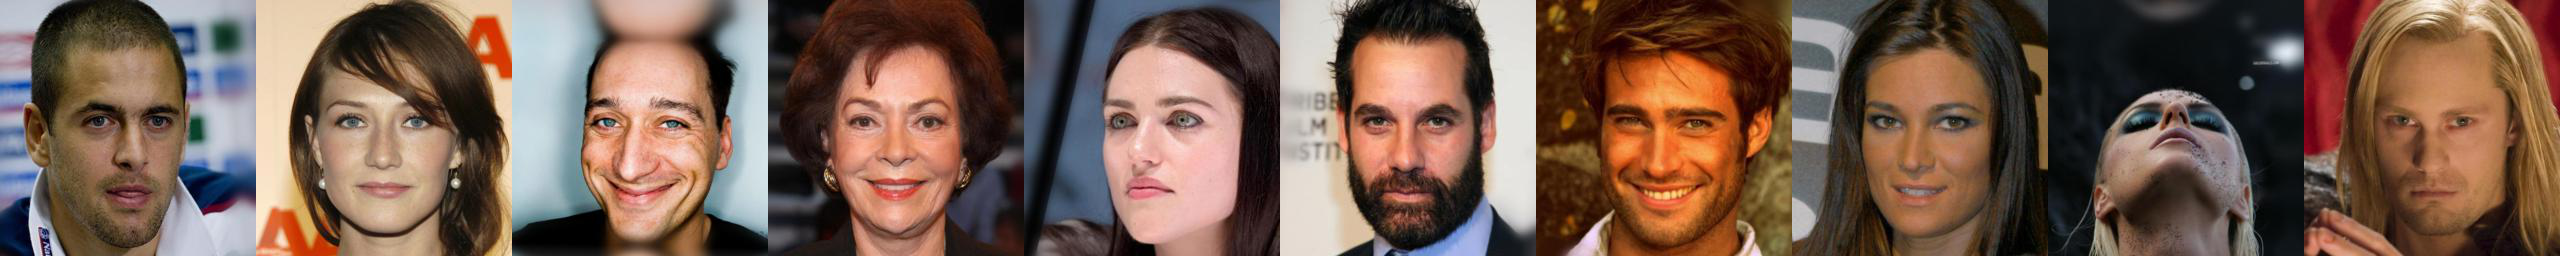

In [ ]:
orig_im = test_images.numpy()
print("Original test images")
save_n_show(orig_im, [1, n_images], image_shape, f'{H.save_dir}/orig_test.png', show=True)

Reconstructions.

Generation of 10 new images for 1x resolution
printing samples to ./saved_models/test/recon_test-res-1x.png


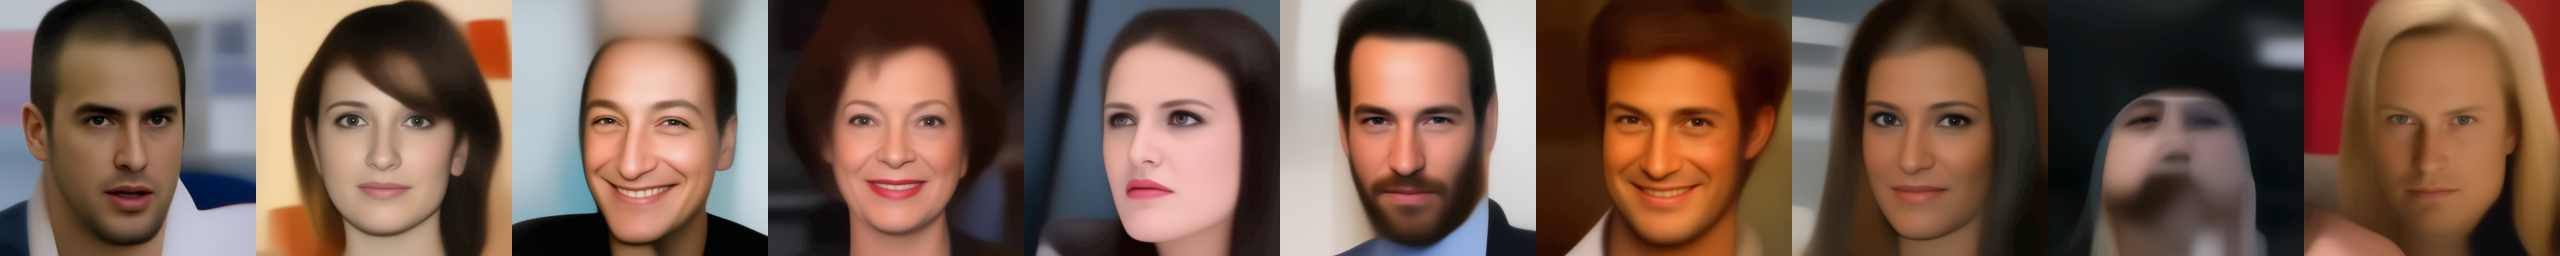

Generation of 10 new images for 2x resolution
printing samples to ./saved_models/test/recon_test-res-2x.png


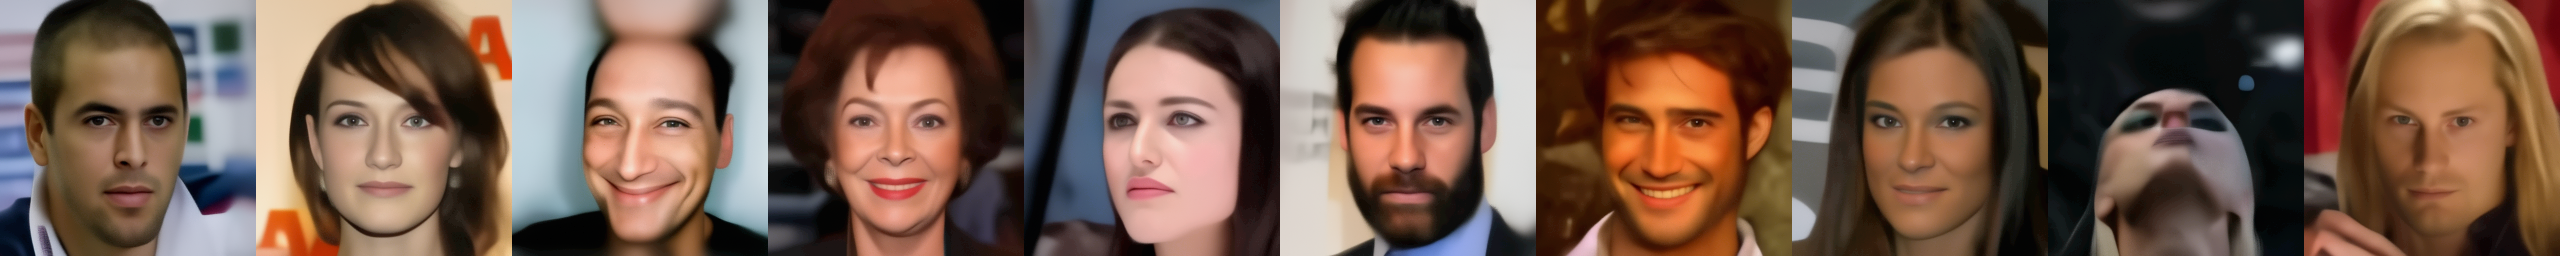

Generation of 10 new images for 3x resolution
printing samples to ./saved_models/test/recon_test-res-3x.png


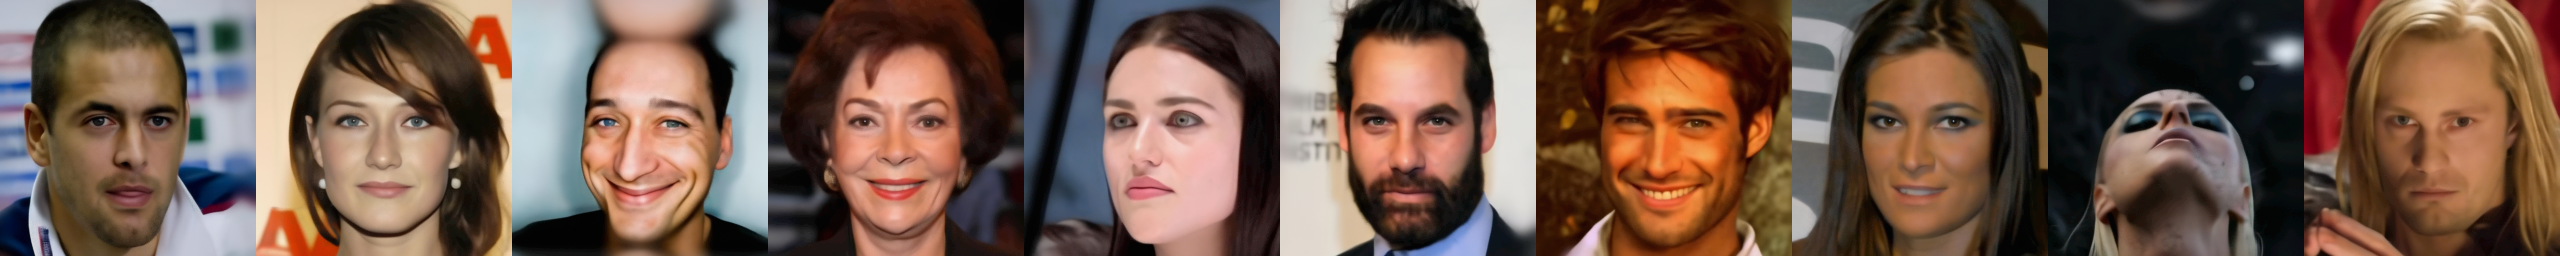

In [ ]:
for i,r in enumerate(recons):
  print("="*25)
  print(f"Generation of {n_images} new images for {i+1}x resolution")
  print("="*25)
  fname = f'{H.save_dir}/recon_test-res-{i+1}x.png'
  save_n_show(r, [1, n_images], image_shape, fname, show=True)